In [1]:
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.applications import VGG16
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from IPython.display import clear_output

Using TensorFlow backend.


In [2]:
base_model=VGG16(weights='imagenet',include_top=False) #imports the VGG model and discards the last 1000 neuron layer.

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(3,activation='softmax')(x) #final layer with activation

In [3]:
model=Model(inputs=base_model.input,outputs=preds)

In [4]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
print("Saved model to disk")
 
# later...
 

Saved model to disk


In [3]:
#model.load_weights("weights00000006.h5")
for i,layer in enumerate(model.layers):
  print(i,layer.name)

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
19 global_average_pooling2d_1
20 dense_1
21 dense_2
22 dense_3
23 dense_4


In [4]:
model.layers[23]

In [5]:
for layer in model.layers:
    layer.trainable=False
# or if we want to set the first 20 layers of the network to be non-trainable
for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

In [6]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

train_generator=train_datagen.flow_from_directory('data/train/',
                                                 target_size=(105,105),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode="categorical",
                                                 shuffle=True)


Found 1018 images belonging to 3 classes.


In [7]:
filepath="output_transf/weights-improvement-{epoch:02d}.hdf5"
#checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
mc = keras.callbacks.ModelCheckpoint('output_transf/weights{epoch:08d}.h5', 
                                     save_weights_only=True, period=1)

In [8]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',
              metrics=['accuracy'])


In [9]:
step_size_train=train_generator.n//train_generator.batch_size
vgg16_fit = model.fit_generator(generator=train_generator,
                               steps_per_epoch=step_size_train,
                               epochs=4,
                                callbacks = [mc])

Epoch 1/4
31/31 [==============================] - 2164s 70s/step - loss: 0.6872 - acc: 0.7186
Epoch 2/4
31/31 [==============================] - 2115s 68s/step - loss: 0.1971 - acc: 0.9209
Epoch 3/4
31/31 [==============================] - 2075s 67s/step - loss: 0.1437 - acc: 0.9496
Epoch 4/4
31/31 [==============================] - 2563s 83s/step - loss: 0.0966 - acc: 0.9627


In [10]:
import matplotlib.pyplot as plt

%matplotlib inline

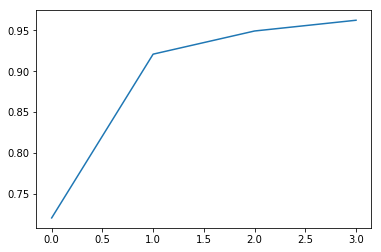

In [11]:
loss = vgg16_fit.history['acc']
#val_loss = vgg16_fit.history['val_loss']
plt.plot(loss)
#plt.plot(val_loss)
#plt.legend(['loss', 'val_loss'])
plt.show()

In [12]:
#model.save_weights("VGG16_transfer_adam_b_crossentropy.h5")

In [13]:
 
val_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

val_generator=val_datagen.flow_from_directory('data/validation/',
                                                 target_size=(105,105),
                                                 color_mode='rgb',
                                                 batch_size=1,
                                                 class_mode='categorical',
                                                 shuffle=False)



Found 159 images belonging to 3 classes.


In [14]:
filenames = val_generator.filenames
nb_samples = len(filenames)

predict = model.predict_generator(val_generator,steps = nb_samples)

In [15]:
loss, acc = model.evaluate_generator(val_generator, steps=nb_samples, verbose=0)

In [16]:
loss,acc 

(0.2935399464800529, 0.89937106918239)

In [ ]:
# Test

In [25]:
model2=Model(inputs=base_model.input,outputs=preds)
model2.load_weights("output_transf/weights00000003.h5")
model2.compile(optimizer='Adam',loss='categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
loss, acc = model2.evaluate_generator(val_generator, steps=nb_samples, verbose=0)

In [27]:
loss,acc

(0.2875893786856852, 0.89937106918239)

In [28]:
model3=Model(inputs=base_model.input,outputs=preds)
model3.load_weights("output_transf/weights00000002.h5")
model3.compile(optimizer='Adam',loss='categorical_crossentropy',
              metrics=['accuracy'])
loss, acc = model3.evaluate_generator(val_generator, steps=nb_samples, verbose=0)

In [29]:
loss,acc

(0.32186691312678745, 0.89937106918239)

In [30]:

def to_fully_conv(model):

    new_model = Sequential()

    #input_layer = InputLayer(input_shape=(None, None, 3), name="input_new")

    #new_model.add(input_layer)

    for layer in model.layers:
        print(layer)
        if "GlobalAveragePooling2D" in str(layer):
            flattened_ipt = True
            f_dim = layer.input_shape

        elif "Dense" in str(layer):

            input_shape = layer.input_shape
            output_dim =  layer.get_weights()[1].shape[0]
            W,b = layer.get_weights()

            if flattened_ipt:
                shape = (f_dim[1],f_dim[2],f_dim[3],output_dim)
                new_W = W.reshape(shape)
                new_layer = Convolution2D(output_dim,
                                          (f_dim[1],f_dim[2]),
                                          strides=(1,1),
                                          activation=layer.activation,
                                          padding='valid',
                                          weights=[new_W,b])
                flattened_ipt = False

            else:
                shape = (1,1,input_shape[1],output_dim)
                new_W = W.reshape(shape)
                new_layer = Convolution2D(output_dim,
                                          (1,1),
                                          strides=(1,1),
                                          activation=layer.activation,
                                          padding='valid',
                                          weights=[new_W,b])


        else:
            new_layer = layer
            
        new_model.add(new_layer)
        flattened_ipt = False
    return new_model

In [32]:
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.engine import InputLayer
import keras
new_model = to_fully_conv(model2)

In [33]:
example_not_stocked = "data/train/Not_Stocked/not_stocked_0_2371.jpeg"

In [35]:
import cv2
img_not_stocked = cv2.imread(example_not_stocked)
img_not_stocked = cv2.cvtColor(img_not_stocked, cv2.COLOR_BGR2RGB)

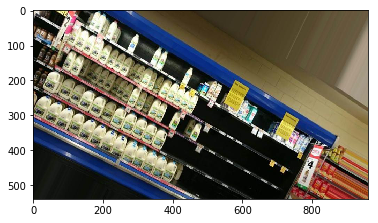

In [36]:
plt.imshow(img_not_stocked)

In [38]:
def process_pred_img(img, w = 105, h = 105):
    img = cv2.resize(img,(h,w))
    img = img.reshape(1,w,h,3)
    return(img)

h,w = 105,105
img_not_stocked = cv2.resize(img_not_stocked,(h,w))

In [39]:
im_ns = process_pred_img(img_not_stocked, 
                        w = 200, h=200)

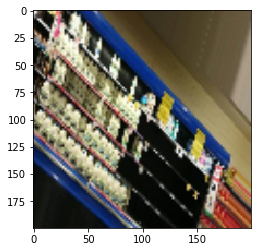

In [40]:
plt.imshow(im_ns[0])

In [89]:
x = process_pred_img(img_not_stocked, w = 300, h=300)
ns = new_model.predict(np.array(x))

In [ ]:
from seaborn import heatmap

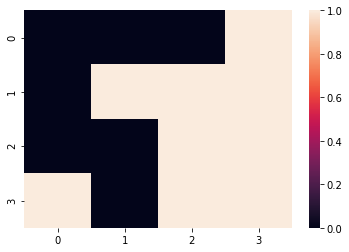

In [90]:
heatmap(ns[0,:,:,0])

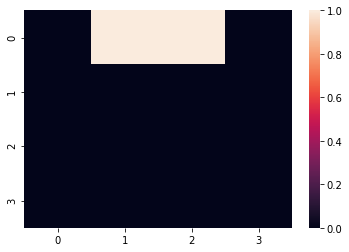

In [91]:
heatmap(ns[0,:,:,1])

In [58]:
ns[0,:,:,2][ns[0,:,:,2] <=.7] = 0

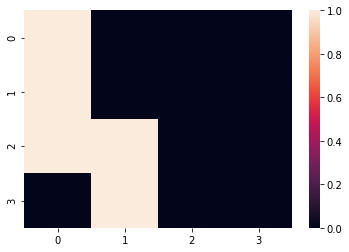

In [92]:
heatmap(ns[0,:,:,2])

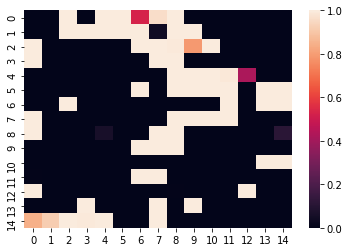

In [60]:
heatmap(ns[0,:,:,1])

In [61]:
ns[0,:,:,1][ns[0,:,:,1] <=.7] = 0

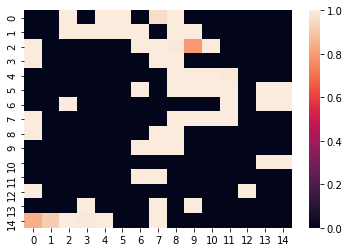

In [62]:
heatmap(ns[0,:,:,1])

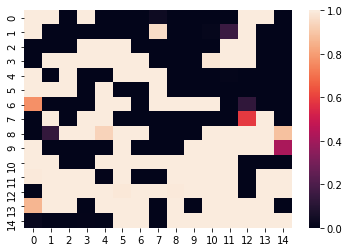

In [63]:
heatmap(ns[0,:,:,0])

In [64]:
ns[0,:,:,0][ns[0,:,:,0] <=.7] = 0

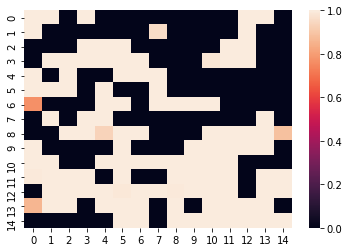

In [65]:
heatmap(ns[0,:,:,0])

In [88]:
scales = np.arange(0.25, 1.05, 0.05)